# Libraries

In [2]:
import os, os.path
import numpy as np
import pandas as pd
import cv2 as cv
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from pathlib import Path


from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
features_path = Path.cwd()
notebooks_path = features_path.parent
repo_path = notebooks_path.parent
os.chdir(str(features_path))
#print current working directory
print(notebooks_path)

/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Machine_Learning/notebooks


# Classes

In [4]:
class path_label():
    """Class to access paths and labels from csv
    """
    def __init__(self, meta=pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t'), classif='binary', set_name='train') -> None:
        meta = meta.loc[meta['classif'] == classif] #Filter by classif
        meta = meta.loc[meta['set'] == set_name] #Filter by set
        self.paths = list(meta.path)
        self.NH_paths = list(meta.NH_path)
        self. labels = np.array(meta.label)
        self.FOV_x1 = np.array(meta.FOV_x1, dtype=np.int16)
        self.FOV_x2 = np.array(meta.FOV_x2, dtype=np.int16)
        self.FOV_y1 = np.array(meta.FOV_y1, dtype=np.int16)
        self.FOV_y2 = np.array(meta.FOV_y2, dtype=np.int16)

# Functions

## Saving and loading

In [5]:
def save_pickle(file, filename):
    """save as pickle

    Args:
        file (obj): object to save
        filename (str): path of the object to save
    """
    with open(filename, 'wb') as handle:
        pickle.dump(file, handle, pickle.HIGHEST_PROTOCOL)

def open_pickle(filename):
    """open pickle file

    Args:
        filename (str): path of pickle file

    Returns:
        obj: object extracted form pickle
    """
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

## Plotting

In [6]:
def plot_image(im_list, figsize=(15,15), cmap='viridis'):
    """Show set of images

    Args:
        im_list (list): list of images
        figsize (tuple, optional): SIze of the plotting window. Defaults to (15,15).
        cmap (str, optional): color map. Defaults to 'viridis'.
    """
    fig, axs = plt.subplots(nrows=1, ncols=len(im_list), figsize=figsize)
    for i, im in enumerate(im_list):
        axs[i].imshow(im, cmap)

# Data manipulation

In [7]:
def get_metaDF(classif='binary', set_name='train'):
    """Returns meta filtered by classification and set name

    Args:
        classif (str, optional): classification problem. Defaults to 'binary'.
        set_name (str, optional): train or val. Defaults to 'train'.

    Returns:
        dataframe: returns dataframe processed
    """
    meta = pd.read_csv('data/meta_info.csv', sep='\t')
    meta = meta.loc[meta['classif'] == classif] #Filter by classif
    meta = meta.loc[meta['set'] == set_name] #Filter by set
    return meta

## Feature extraction


In [8]:
def color_hist_fv(im, bins):
    """Returns the feature vector as the concatenation of the color spaces histograms

    Args:
        im (array): Image in its channel representation, where te channel dimension is at the end.
        bins (int): number of bins. This also defines the feature vector size, combined with the channel num.
    """
    num_chs = im.shape[2]   
    fv = np.zeros(bins*num_chs, dtype=np.uint16)
    for ch in range(0,num_chs):
        im_ch = im[:,:,ch]
        hist, _ = np.histogram(im_ch.ravel(), bins=bins, range=(0,bins))
        fv[int(ch*fv.shape[0]/num_chs):int((ch+1)*fv.shape[0]/num_chs)] = hist
    
    return fv


def color_hist_extraction(classif, set_name, bins, color_space, noFOV=False, NH=True):
    """Extract histogram as fv given color sapce and bins num

    Args:
        classif (srt): binary or 3_class
        set_name (srt): train or test
        bins (int): number of bins of histogram (num of elements in fv)
        color_space (srt): color space to extract from
        return: fv
    """
    FOV_status = 'noFOV' if noFOV==True else 'wFOV' #Variable for printing FOV state
    dict_colors = { #Color dicitonary
        "RGB": cv.COLOR_BGR2RGB, "HSV": cv.COLOR_BGR2HSV, "HLS": cv.COLOR_BGR2HLS, "LAB": cv.COLOR_BGR2Lab, "YCrCb": cv.COLOR_BGR2YCrCb
    }
    #Read metadata file 
    meta = pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t')

    #Define information object
    info = path_label(meta, classif, set_name)

    #Extraciton settings
    im_num = len(info.paths)#number of images in folder
    fvs = np.zeros(shape=(im_num,bins*3)) #Store feature vector here
    print(f'Shape of fv: {fvs.shape}') #print shape 

    for i in tqdm(range(im_num)): #Go through data
        im = cv.imread(str(repo_path) + '/' + info.paths[i]) if NH==False else cv.imread(str(repo_path) + '/' + info.NH_paths[i])
        im = im[info.FOV_x1[i]:info.FOV_x2[i], info.FOV_y1[i]:info.FOV_y2[i],:] if noFOV==True else im #Use subimage if noFOV is true
        im = cv.cvtColor(im, dict_colors[color_space]) #convert to color space
        fvs[i] = color_hist_fv(im, bins) #get histograms as fv

    if NH==False:
        save_pickle(fvs, str(repo_path) + f'/data/features/color/{color_space}/{classif}_{set_name}_color_hist_{bins}_fv_{FOV_status}.p') #save in pickle
    else:
        save_pickle(fvs, str(repo_path) + f'/data/features/color/{color_space}/{classif}_{set_name}_color_hist_{bins}_fv_{FOV_status}_NH.p') #save in pickle
    return fvs

# Implementation

## Extract features (color basics)

In [25]:
classif='binary'; set_name='val'; bins = 256; color_space='HSV'#Feature extraction settings
FOV_status = 'noFOV' ; f_type = 'color' ; f_name = f'{f_type}_hist_{bins}'
#f = color_hist_extraction(classif, set_name, bins, color_space, noFOV=True, NH=True)

## Train and test

In [10]:
def classifier(method):
    """Select classification method

    Args:
        method (str): knn, svm, rf, etc.

    Returns:
        grid, pipe obj: settings ready to fit
    """
    #ML Training setting
    if(method=='KNN'):
        param_grid = {'classifier__n_neighbors': list(range(1,32))}
        pipe = Pipeline([('scaler', Normalizer()),('classifier',KNeighborsClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = 4)
        return grid, pipe
    elif(method=='RF'):
        param_grid = {'classifier__n_estimators': [100, 200, 400, 1000],}
        pipe = Pipeline([('scaler', Normalizer()),('classifier',RandomForestClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = 4)
        return grid, pipe

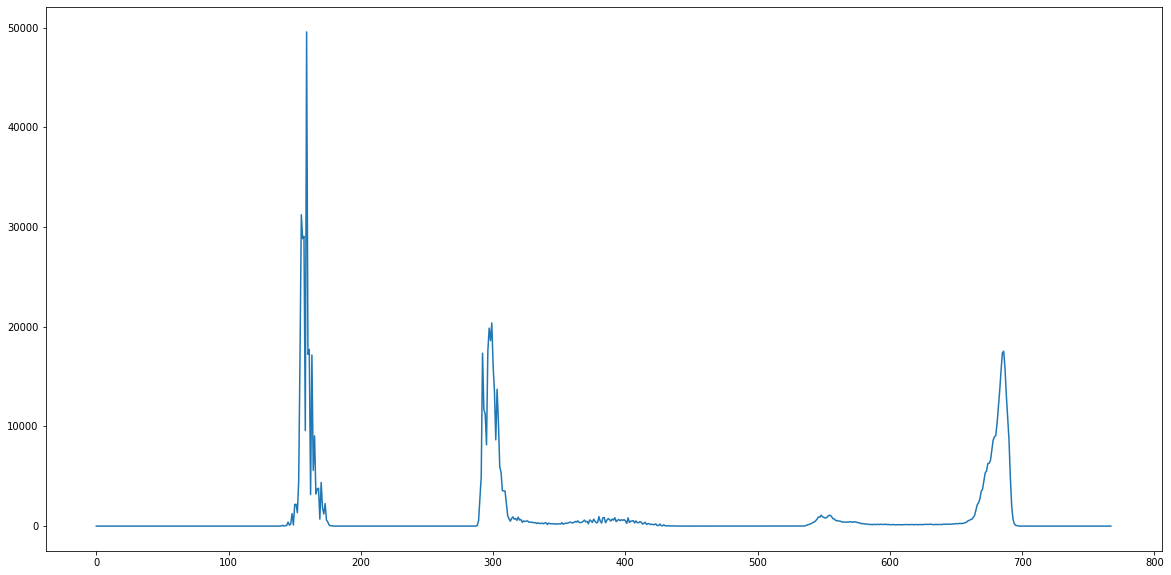

In [27]:
histogram_counts = open_pickle(str(repo_path) + f'/data/features/{f_type}/{color_space}/{classif}_train_{f_name}_fv_{FOV_status}_NH_fv.p')
bin_range = np.arange(histogram_counts.shape[1] + 1)
#plot histograms
plt.figure(figsize=(20,10))
plt.plot(bin_range[:-1], histogram_counts[0], label='Normal')

In [ ]:
#Settings
meta = pd.read_csv(str(repo_path)  + '/data/meta_info.csv', sep='\t')
FOV_status = 'noFOV'
classif = 'binary'; f_type = 'color'; f_name = f'{f_type}_hist_{bins}'

#Read training data
X_train = open_pickle(str(repo_path) + f'/data/features/{f_type}/{color_space}/{classif}_train_{f_name}_fv_{FOV_status}_NH.p')
y_train = path_label(meta, classif, set_name='train').labels

#Read validation data
X_val = open_pickle(str(repo_path) +  f'/data/features/{f_type}/{color_space}/{classif}_val_{f_name}_fv_{FOV_status}_NH.p')
y_val = path_label(meta, classif, set_name='val').labels

In [ ]:
#run model
grid, pipe = classifier('RF')
model = grid.fit(X_train,y_train)
save_pickle(model, str(repo_path) + f'/data/models/{classif}_{pipe.steps[-1][-1]}_{f_name}_{color_space}_{FOV_status}_NH.p') #Save model
y_pred = model.predict(X_val) #predict
acc = np.mean(y_pred == y_val) #accuracy
print(acc)

0.8166491043203372


## Reading models

In [ ]:
#Settings
meta = pd.read_csv('data/meta_info.csv', sep='\t')
classif = 'binary'; f_type = 'color'; bins = 256; f_name = f'{f_type}_hist_{bins}' ; color_space = 'RGB'

model = open_pickle(f'data/models/{classif}_RandomForestClassifier()_{f_name}_{color_space}.p')


#Read validation data
X_val = open_pickle(f'data/features/{f_type}/{color_space}/{classif}_val_{f_name}_fv.p')
y_val = path_label(meta, classif, set_name='val').labels


y_pred = model.predict(X_val) #predict
acc = np.mean(y_pred == y_val) #accuracy
print(acc)

0.8021601685985248
